In [1]:
%load_ext autoreload
%autoreload 2

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
from collections import deque

from controllers.game_controller import GameController
from drl.agent import DRLAgent
from models.players.random_player import RandomPlayer
from models.players.drl_player import DRLPlayer
from utils import get_reward_from_winner

In [3]:
def run_validation(drl_players, n_episodes_validation):
    game_controller = GameController()
    players = [
        drl_players[0],
        RandomPlayer(1)
    ]
    game_controller.load_validation(players)
    
    # Disable train mode
    players[0].train_mode = False

    validation_scores = []
    for i in range(1, n_episodes_validation+1):
        episode_winner = game_controller.run_episode(eval_mode=True)
        validation_score = get_reward_from_winner(0, episode_winner)
        validation_scores.append(validation_score)
        game_controller.game.reset()

    # Re-enable train mode
    players[0].train_mode = True
    
    return np.mean(validation_scores)

In [1]:
def init_train(game_controller, drl_players, n_episodes, checkpoint_each, validate_each, n_episodes_validation,
                   model_path=None, eps_start=1.0, eps_end=0.01, eps_decay=0.999, start_epoch=1):
        train_args = {
            'eps': eps_start,
            'eps_end': eps_end,
            'eps_decay': eps_decay
        }
        
        game_controller.load_train(drl_players)
        for player in range(2):
            drl_players[player].update_epsilon(eps_start)

        winners = []
        try:
            validation_scores = []
            validation_scores_window = deque(maxlen=100)
            start = time.time()
            for i in range(start_epoch, start_epoch+n_episodes):
                episode_winner = game_controller.run_episode(train_mode=True, train_args=train_args)
                winners.append(episode_winner)
                game_controller.game.reset()

                if i%validate_each == 0:
                    mean_validation_score = run_validation(drl_players, n_episodes_validation)

                    validation_scores.append(mean_validation_score)
                    validation_scores_window.append(mean_validation_score)
                    mean_validation_score_last_runs = np.mean(validation_scores_window)

                    try:
                        agent_losses = drl_players[0].agent.get_losses()
                        actor_loss = '{:+6.3f}'.format(agent_losses['actor_losses'][-1])
                        critic_loss = '{:+6.3f}'.format(agent_losses['critic_losses'][-1])
                    except:
                        actor_loss = '------'
                        critic_loss = '------'
                    print("\rEpisode #{:4d}  |  "
                        "Val. Score: {:+5.2f}   |  "
                        "Avg. Val. Score: {:+5.2f}  |  "
                        "Epsilon: {:5.3f}\n"
                        "                  "
                        "Actor Loss: {}  |  "
                        "Critic Loss: {}     |  "
                        "Time Elapsed: {:.2f}s".format(i, mean_validation_score,
                                            mean_validation_score_last_runs, train_args['eps'],
                                            actor_loss, critic_loss, time.time() - start)
                    )

                if i%checkpoint_each == 0:
                    drl_players[0].agent.save_model()
                    print('Checkpoint saved!')
        except KeyboardInterrupt:
            pass

        # save model after all episodes
        drl_players[0].agent.save_model(model_path)
        print('Model saved!')

        return validation_scores

In [5]:
def plot_scores(metrics, validate_each):
    new_index = pd.RangeIndex(start=1, stop=1+len(metrics)*validate_each, step=validate_each)
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(new_index, metrics)
    series = pd.Series(metrics)
    series.index = new_index
    series.rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Score')
    plt.show();    

In [6]:
controller = GameController()
drl_agent = DRLAgent(
    state_size=controller.game.N*controller.game.N+2,
    bid_action_size=1,
    board_action_size=controller.game.N*controller.game.N,
    seed=None,
    checkpoint_path='../checkpoints/checkpoint.pt'
)

In [7]:
n_episodes=50000
checkpoint_each=1000
validate_each=100
n_episodes_validation=10
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.999
drl_players = [DRLPlayer(i, controller.game, drl_agent, train_mode=True) for i in range(2)]
validation_scores = init_train(controller, drl_players, model_path='../checkpoints/model.pt',
                                n_episodes=n_episodes, checkpoint_each=checkpoint_each,
                                validate_each=validate_each, n_episodes_validation=n_episodes_validation,
                                eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)


Episode # 100  |  Val. Score: +0.10   |  Avg. Val. Score: +0.10  |  Epsilon: 0.927
                  Actor Loss: -0.020  |  Critic Loss: +0.058     |  Time Elapsed: 15.58s
Episode # 200  |  Val. Score: -0.60   |  Avg. Val. Score: -0.25  |  Epsilon: 0.865
                  Actor Loss: -0.051  |  Critic Loss: +0.060     |  Time Elapsed: 48.67s
Episode # 300  |  Val. Score: -0.20   |  Avg. Val. Score: -0.23  |  Epsilon: 0.805
                  Actor Loss: -0.074  |  Critic Loss: +0.065     |  Time Elapsed: 85.27s
Episode # 400  |  Val. Score: +0.30   |  Avg. Val. Score: -0.10  |  Epsilon: 0.751
                  Actor Loss: -0.158  |  Critic Loss: +0.065     |  Time Elapsed: 129.19s
Episode # 500  |  Val. Score: +0.20   |  Avg. Val. Score: -0.04  |  Epsilon: 0.704
                  Actor Loss: -0.207  |  Critic Loss: +0.073     |  Time Elapsed: 185.17s
Episode # 600  |  Val. Score: +0.20   |  Avg. Val. Score: +0.00  |  Epsilon: 0.655
                  Actor Loss: -0.286  |  Critic Loss: +

Episode #4800  |  Val. Score: -0.40   |  Avg. Val. Score: -0.10  |  Epsilon: 0.024
                  Actor Loss: -2.904  |  Critic Loss: +0.929     |  Time Elapsed: 2873.46s
Episode #4900  |  Val. Score: -0.40   |  Avg. Val. Score: -0.11  |  Epsilon: 0.022
                  Actor Loss: -2.987  |  Critic Loss: +0.903     |  Time Elapsed: 2917.52s
Episode #5000  |  Val. Score: -0.30   |  Avg. Val. Score: -0.11  |  Epsilon: 0.021
                  Actor Loss: -3.037  |  Critic Loss: +0.922     |  Time Elapsed: 2957.16s
Checkpoint saved!
Episode #5100  |  Val. Score: +0.10   |  Avg. Val. Score: -0.11  |  Epsilon: 0.019
                  Actor Loss: -3.044  |  Critic Loss: +1.085     |  Time Elapsed: 2996.49s
Episode #5200  |  Val. Score: -0.50   |  Avg. Val. Score: -0.12  |  Epsilon: 0.018
                  Actor Loss: -3.155  |  Critic Loss: +1.041     |  Time Elapsed: 3035.73s
Episode #5300  |  Val. Score: +0.00   |  Avg. Val. Score: -0.12  |  Epsilon: 0.016
                  Actor Loss:

Episode #9500  |  Val. Score: +0.30   |  Avg. Val. Score: -0.09  |  Epsilon: 0.010
                  Actor Loss: -3.255  |  Critic Loss: +1.095     |  Time Elapsed: 4729.23s
Episode #9600  |  Val. Score: -0.60   |  Avg. Val. Score: -0.09  |  Epsilon: 0.010
                  Actor Loss: -3.242  |  Critic Loss: +1.138     |  Time Elapsed: 4770.52s
Episode #9700  |  Val. Score: -0.40   |  Avg. Val. Score: -0.10  |  Epsilon: 0.010
                  Actor Loss: -3.201  |  Critic Loss: +1.318     |  Time Elapsed: 4812.26s
Episode #9800  |  Val. Score: -0.40   |  Avg. Val. Score: -0.10  |  Epsilon: 0.010
                  Actor Loss: -3.163  |  Critic Loss: +1.095     |  Time Elapsed: 4851.84s
Episode #9900  |  Val. Score: +0.40   |  Avg. Val. Score: -0.09  |  Epsilon: 0.010
                  Actor Loss: -3.152  |  Critic Loss: +1.100     |  Time Elapsed: 4892.22s
Episode #10000  |  Val. Score: +0.30   |  Avg. Val. Score: -0.09  |  Epsilon: 0.010
                  Actor Loss: -3.040  |  Criti

Episode #14200  |  Val. Score: -0.20   |  Avg. Val. Score: -0.08  |  Epsilon: 0.010
                  Actor Loss: -3.547  |  Critic Loss: +1.625     |  Time Elapsed: 6562.83s
Episode #14300  |  Val. Score: +0.40   |  Avg. Val. Score: -0.07  |  Epsilon: 0.010
                  Actor Loss: -3.633  |  Critic Loss: +1.617     |  Time Elapsed: 6601.54s
Episode #14400  |  Val. Score: -0.50   |  Avg. Val. Score: -0.07  |  Epsilon: 0.010
                  Actor Loss: -3.607  |  Critic Loss: +1.528     |  Time Elapsed: 6639.57s
Episode #14500  |  Val. Score: +0.10   |  Avg. Val. Score: -0.07  |  Epsilon: 0.010
                  Actor Loss: -3.622  |  Critic Loss: +1.444     |  Time Elapsed: 6679.36s
Episode #14600  |  Val. Score: +0.20   |  Avg. Val. Score: -0.06  |  Epsilon: 0.010
                  Actor Loss: -3.562  |  Critic Loss: +1.520     |  Time Elapsed: 6720.28s
Episode #14700  |  Val. Score: +0.10   |  Avg. Val. Score: -0.06  |  Epsilon: 0.010
                  Actor Loss: -3.610  |  

Episode #18900  |  Val. Score: +0.20   |  Avg. Val. Score: +0.04  |  Epsilon: 0.010
                  Actor Loss: -2.124  |  Critic Loss: +0.543     |  Time Elapsed: 8345.35s
Episode #19000  |  Val. Score: +0.40   |  Avg. Val. Score: +0.04  |  Epsilon: 0.010
                  Actor Loss: -2.076  |  Critic Loss: +0.576     |  Time Elapsed: 8380.76s
Checkpoint saved!
Episode #19100  |  Val. Score: -0.60   |  Avg. Val. Score: +0.03  |  Epsilon: 0.010
                  Actor Loss: -2.160  |  Critic Loss: +0.528     |  Time Elapsed: 8416.87s
Episode #19200  |  Val. Score: +0.20   |  Avg. Val. Score: +0.04  |  Epsilon: 0.010
                  Actor Loss: -2.060  |  Critic Loss: +0.511     |  Time Elapsed: 8452.57s
Episode #19300  |  Val. Score: +0.40   |  Avg. Val. Score: +0.04  |  Epsilon: 0.010
                  Actor Loss: -2.072  |  Critic Loss: +0.472     |  Time Elapsed: 8488.48s
Episode #19400  |  Val. Score: +0.00   |  Avg. Val. Score: +0.04  |  Epsilon: 0.010
                  Actor

Episode #23600  |  Val. Score: +0.20   |  Avg. Val. Score: +0.13  |  Epsilon: 0.010
                  Actor Loss: -2.104  |  Critic Loss: +0.520     |  Time Elapsed: 10183.49s
Episode #23700  |  Val. Score: -0.20   |  Avg. Val. Score: +0.13  |  Epsilon: 0.010
                  Actor Loss: -2.114  |  Critic Loss: +0.570     |  Time Elapsed: 10220.69s
Episode #23800  |  Val. Score: +0.40   |  Avg. Val. Score: +0.13  |  Epsilon: 0.010
                  Actor Loss: -2.096  |  Critic Loss: +0.562     |  Time Elapsed: 10258.74s
Episode #23900  |  Val. Score: +0.00   |  Avg. Val. Score: +0.14  |  Epsilon: 0.010
                  Actor Loss: -2.114  |  Critic Loss: +0.573     |  Time Elapsed: 10300.14s
Episode #24000  |  Val. Score: +0.00   |  Avg. Val. Score: +0.14  |  Epsilon: 0.010
                  Actor Loss: -2.116  |  Critic Loss: +0.549     |  Time Elapsed: 10340.86s
Checkpoint saved!
Episode #24100  |  Val. Score: +0.40   |  Avg. Val. Score: +0.14  |  Epsilon: 0.010
                  

Episode #28300  |  Val. Score: +0.40   |  Avg. Val. Score: +0.20  |  Epsilon: 0.010
                  Actor Loss: -2.459  |  Critic Loss: +0.753     |  Time Elapsed: 12157.95s
Episode #28400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.20  |  Epsilon: 0.010
                  Actor Loss: -2.495  |  Critic Loss: +0.709     |  Time Elapsed: 12195.52s
Episode #28500  |  Val. Score: +0.40   |  Avg. Val. Score: +0.20  |  Epsilon: 0.010
                  Actor Loss: -2.473  |  Critic Loss: +0.740     |  Time Elapsed: 12233.55s
Episode #28600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.21  |  Epsilon: 0.010
                  Actor Loss: -2.489  |  Critic Loss: +0.776     |  Time Elapsed: 12271.40s
Episode #28700  |  Val. Score: +0.10   |  Avg. Val. Score: +0.21  |  Epsilon: 0.010
                  Actor Loss: -2.532  |  Critic Loss: +0.685     |  Time Elapsed: 12309.16s
Episode #28800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.21  |  Epsilon: 0.010
                  Actor Loss: -2.521

Episode #33000  |  Val. Score: +0.60   |  Avg. Val. Score: +0.25  |  Epsilon: 0.010
                  Actor Loss: -2.509  |  Critic Loss: +0.670     |  Time Elapsed: 14190.34s
Checkpoint saved!
Episode #33100  |  Val. Score: -0.20   |  Avg. Val. Score: +0.25  |  Epsilon: 0.010
                  Actor Loss: -2.462  |  Critic Loss: +0.750     |  Time Elapsed: 14239.76s
Episode #33200  |  Val. Score: -0.30   |  Avg. Val. Score: +0.24  |  Epsilon: 0.010
                  Actor Loss: -2.475  |  Critic Loss: +0.743     |  Time Elapsed: 14289.20s
Episode #33300  |  Val. Score: +0.00   |  Avg. Val. Score: +0.24  |  Epsilon: 0.010
                  Actor Loss: -2.480  |  Critic Loss: +0.709     |  Time Elapsed: 14336.97s
Episode #33400  |  Val. Score: +0.20   |  Avg. Val. Score: +0.24  |  Epsilon: 0.010
                  Actor Loss: -2.502  |  Critic Loss: +0.783     |  Time Elapsed: 14386.08s
Episode #33500  |  Val. Score: -0.20   |  Avg. Val. Score: +0.24  |  Epsilon: 0.010
                  

Episode #37700  |  Val. Score: +0.30   |  Avg. Val. Score: +0.18  |  Epsilon: 0.010
                  Actor Loss: -3.168  |  Critic Loss: +1.131     |  Time Elapsed: 16351.13s
Episode #37800  |  Val. Score: +0.10   |  Avg. Val. Score: +0.17  |  Epsilon: 0.010
                  Actor Loss: -3.158  |  Critic Loss: +1.300     |  Time Elapsed: 16393.29s
Episode #37900  |  Val. Score: -0.50   |  Avg. Val. Score: +0.16  |  Epsilon: 0.010
                  Actor Loss: -3.211  |  Critic Loss: +1.279     |  Time Elapsed: 16435.90s
Episode #38000  |  Val. Score: -0.30   |  Avg. Val. Score: +0.15  |  Epsilon: 0.010
                  Actor Loss: -3.180  |  Critic Loss: +1.277     |  Time Elapsed: 16479.44s
Checkpoint saved!
Episode #38100  |  Val. Score: +0.00   |  Avg. Val. Score: +0.15  |  Epsilon: 0.010
                  Actor Loss: -3.244  |  Critic Loss: +1.192     |  Time Elapsed: 16522.36s
Episode #38200  |  Val. Score: -0.20   |  Avg. Val. Score: +0.15  |  Epsilon: 0.010
                  

Episode #42400  |  Val. Score: +0.30   |  Avg. Val. Score: +0.02  |  Epsilon: 0.010
                  Actor Loss: -3.405  |  Critic Loss: +1.346     |  Time Elapsed: 18598.87s
Episode #42500  |  Val. Score: +0.00   |  Avg. Val. Score: +0.02  |  Epsilon: 0.010
                  Actor Loss: -3.395  |  Critic Loss: +1.417     |  Time Elapsed: 18649.62s
Episode #42600  |  Val. Score: +0.00   |  Avg. Val. Score: +0.02  |  Epsilon: 0.010
                  Actor Loss: -3.358  |  Critic Loss: +1.311     |  Time Elapsed: 18700.81s
Episode #42700  |  Val. Score: -0.30   |  Avg. Val. Score: +0.02  |  Epsilon: 0.010
                  Actor Loss: -3.458  |  Critic Loss: +1.222     |  Time Elapsed: 18752.20s
Episode #42800  |  Val. Score: -0.10   |  Avg. Val. Score: +0.02  |  Epsilon: 0.010
                  Actor Loss: -3.449  |  Critic Loss: +1.457     |  Time Elapsed: 18803.67s
Episode #42900  |  Val. Score: -0.30   |  Avg. Val. Score: +0.02  |  Epsilon: 0.010
                  Actor Loss: -3.422

Episode #47100  |  Val. Score: -0.10   |  Avg. Val. Score: -0.01  |  Epsilon: 0.010
                  Actor Loss: -3.684  |  Critic Loss: +1.500     |  Time Elapsed: 21121.88s
Episode #47200  |  Val. Score: -0.30   |  Avg. Val. Score: -0.02  |  Epsilon: 0.010
                  Actor Loss: -3.698  |  Critic Loss: +1.477     |  Time Elapsed: 21176.50s
Episode #47300  |  Val. Score: -0.30   |  Avg. Val. Score: -0.03  |  Epsilon: 0.010
                  Actor Loss: -3.661  |  Critic Loss: +1.611     |  Time Elapsed: 21231.19s
Episode #47400  |  Val. Score: +0.20   |  Avg. Val. Score: -0.03  |  Epsilon: 0.010
                  Actor Loss: -3.740  |  Critic Loss: +1.604     |  Time Elapsed: 21285.49s
Episode #47500  |  Val. Score: +0.00   |  Avg. Val. Score: -0.03  |  Epsilon: 0.010
                  Actor Loss: -3.691  |  Critic Loss: +1.795     |  Time Elapsed: 21339.99s
Episode #47600  |  Val. Score: +0.30   |  Avg. Val. Score: -0.03  |  Epsilon: 0.010
                  Actor Loss: -3.706

In [8]:
final_validation_scores = validation_scores

In [9]:
# # Continue training
# validation_scores_continued = init_train(controller, drl_players, model_path='../checkpoints/model.pt',
#                    eps_start=0.019, eps_end=eps_end, eps_decay=eps_decay, start_epoch=30001)

In [10]:
# final_validation_scores += validation_scores_continued

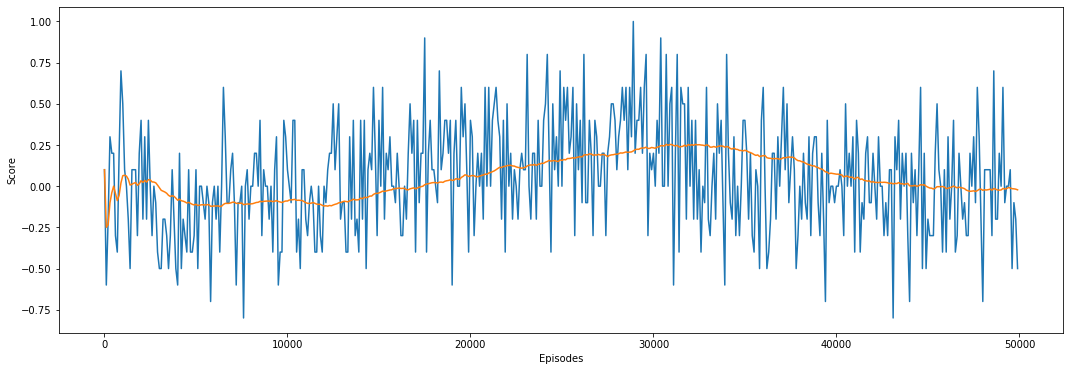

In [11]:
plot_scores(final_validation_scores, validate_each)

In [184]:
# drl_agent.save_model('../checkpoints/model_final.pt')

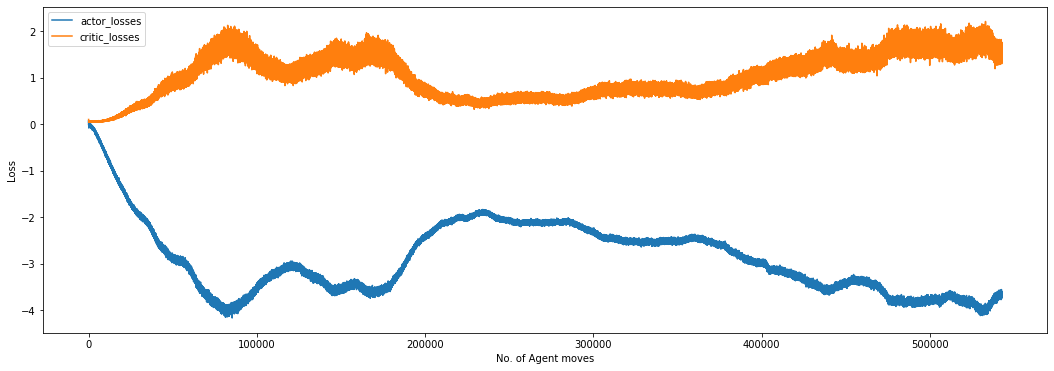

In [13]:
# Plot loss functions
losses = drl_agent.get_losses()
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(losses['actor_losses'], label='actor_losses')
ax.plot(losses['critic_losses'], label='critic_losses')
ax.set_xlabel('No. of Agent moves')
ax.set_ylabel('Loss')
# ax.plot(list((critic_loss - actor_loss) for critic_loss, actor_loss in zip(losses['critic_losses'][:], losses['actor_losses'][:])), label='diff_losses')
plt.legend(loc='best')
plt.show();

In [14]:
controller.reset_game()

Select one of the following players to be player 1
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
Input desired player number: 0
Select one of the following players to be player 2
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
Input desired player number: 1
                  1 | 2 | 3 
                 ---+---+---
                  4 | 5 | 6 
                 ---+---+---
                  7 | 8 | 9 
Player 1 (X): 100           Player 2 (O): 100

Player 1 DRLPlayer(X) bidding...
Player 2 HumanPlayer(O) bidding...
5
Player 1 DRLPlayer(X) bid: 97  |  Player 2 HumanPlayer(O) bid: 5  |  
Player 1 DRLPlayer(X) won the bet
                  1 | 2 | 3 
                 ---+---+---
                  X | 5 | 6 
                 ---+---+---
                  7 | 8 | 9 
Player 1 (X):   3           Player 2 (O): 197

Player 1 DRLPlayer(X) bidding...
Player 2 HumanPlayer(O) b

In [15]:
sample = drl_agent.agent.memory.sample()
sample

(tensor([[ 0.,  1.,  0.,  ..., -1.,  1., -1.],
         [ 1.,  0., -1.,  ..., -1.,  0., -1.],
         [ 1.,  0., -1.,  ..., -1., -1., -1.],
         ...,
         [ 0.,  1., -1.,  ...,  0., -1., -1.],
         [ 0.,  1.,  1.,  ..., -1.,  0.,  0.],
         [ 0.,  1.,  0.,  ..., -1., -1., -1.]], device='cuda:0'),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.8950, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        device='cuda:0'),
 tensor([[-0.0500],
         [-0.0500],
         [-0.0500],
         ...,
         [-0.0500],
         [-0.0500],
         [-0.0500]], device='cuda:0'),
 tensor([[ 1.0000,  0.0000,  0.0000,  ..., -1.0000,  1.0000,  1.0000],
         [ 0.0000,  1.0000, -1

In [16]:
states, actions, rewards, next_states, dones = sample

In [17]:
max((state[0]+state[1]) for state in states)

tensor(1., device='cuda:0')

In [18]:
min((state[0]+state[1]) for state in states)

tensor(1., device='cuda:0')

In [19]:
max((state[0]+state[1]) for state in states)

tensor(1., device='cuda:0')

In [34]:
pd.Series(rewards.cpu().flatten().numpy()).value_counts()

-0.05    884
-1.00     68
 1.00     65
 0.00      7
dtype: int64

In [20]:
drl_players[0].last_state

tensor([ 0.4700,  0.5300,  1.0000,  1.0000, -1.0000,  0.0000, -1.0000,  0.0000,
         1.0000,  0.0000,  1.0000])

In [21]:
drl_players[0].curr_state

tensor([ 0.4700,  0.5300,  1.0000,  1.0000, -1.0000,  0.0000, -1.0000,  0.0000,
         1.0000,  0.0000,  1.0000])

In [22]:
drl_players[0]._format_state_to_agent(drl_players[0].curr_state)

tensor([ 0.0023,  0.0026,  1.0000,  1.0000, -1.0000,  0.0000, -1.0000,  0.0000,
         1.0000,  0.0000,  1.0000])

In [23]:
noise = drl_agent.agent.noise.sample()
noise

array([-0.07893809])

### Analysis of first move Critic values

In [160]:
import torch
from torchsummary import summary

In [35]:
controller.game.reset()
drl_player = drl_players[0]
agent_actor = drl_player.agent.agent.actor_local
agent_critic = drl_player.agent.agent.critic_local

In [47]:
summary(agent_actor, (11,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]           4,800
             PReLU-2                  [-1, 400]               1
            Linear-3                  [-1, 300]         120,300
             PReLU-4                  [-1, 300]               1
            Linear-5                    [-1, 1]             301
           Sigmoid-6                    [-1, 1]               0
            Linear-7                    [-1, 9]           2,709
           Softmax-8                    [-1, 9]               0
Total params: 128,112
Trainable params: 128,112
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.49
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


In [56]:
summary(agent_critic, [(11,), (10,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]           4,800
             PReLU-2                  [-1, 400]               1
            Linear-3                  [-1, 300]         123,300
             PReLU-4                  [-1, 300]               1
            Linear-5                    [-1, 1]             301
Total params: 128,403
Trainable params: 128,403
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.49
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


In [64]:
game = controller.game
game.get_state_array(), drl_player._format_state_to_agent(game.get_state_array())

([100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 tensor([ 0.5000,  0.5000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000]))

In [139]:
drl_agent.act(drl_player._format_state_to_agent(game.get_state_array()))

array([[9.9971420e-01, 1.5979709e-01, 8.3985084e-05, 3.4771480e-07,
        2.3893546e-04, 1.1137453e-03, 4.8535928e-01, 1.8784028e-01,
        1.6543502e-01, 1.3136092e-04]], dtype=float32)

In [122]:
drl_player._get_action_from_agent(drl_agent.act(drl_player._format_state_to_agent(game.get_state_array())), 100)

(100, 5)

In [156]:
curr_state = drl_player._format_state_to_agent(game.get_state_array()).cuda().unsqueeze(0)
curr_state

tensor([[ 0.5000,  0.5000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000]], device='cuda:0')

In [164]:
action = agent_actor(curr_state)
action

tensor([[9.9971e-01, 1.5980e-01, 8.3985e-05, 3.4771e-07, 2.3894e-04, 1.1137e-03,
         4.8536e-01, 1.8784e-01, 1.6544e-01, 1.3136e-04]], device='cuda:0',
       grad_fn=<CatBackward>)

In [162]:
action = torch.Tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]).cuda()
action

tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [165]:
agent_critic(curr_state, action)

tensor([[4.9187]], device='cuda:0', grad_fn=<AddmmBackward>)

In [141]:
agent_critic(drl_player._format_state_to_agent(game.get_state_array()), drl_agent.act(drl_player._format_state_to_agent(game.get_state_array())))

RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

In [174]:
bid = 50
board_move = 2
action = torch.zeros(10)
action[0] = bid/200
action[1+board_move] = 1
action = action.unsqueeze(0).cuda()
action

tensor([[0.2500, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], device='cuda:0')

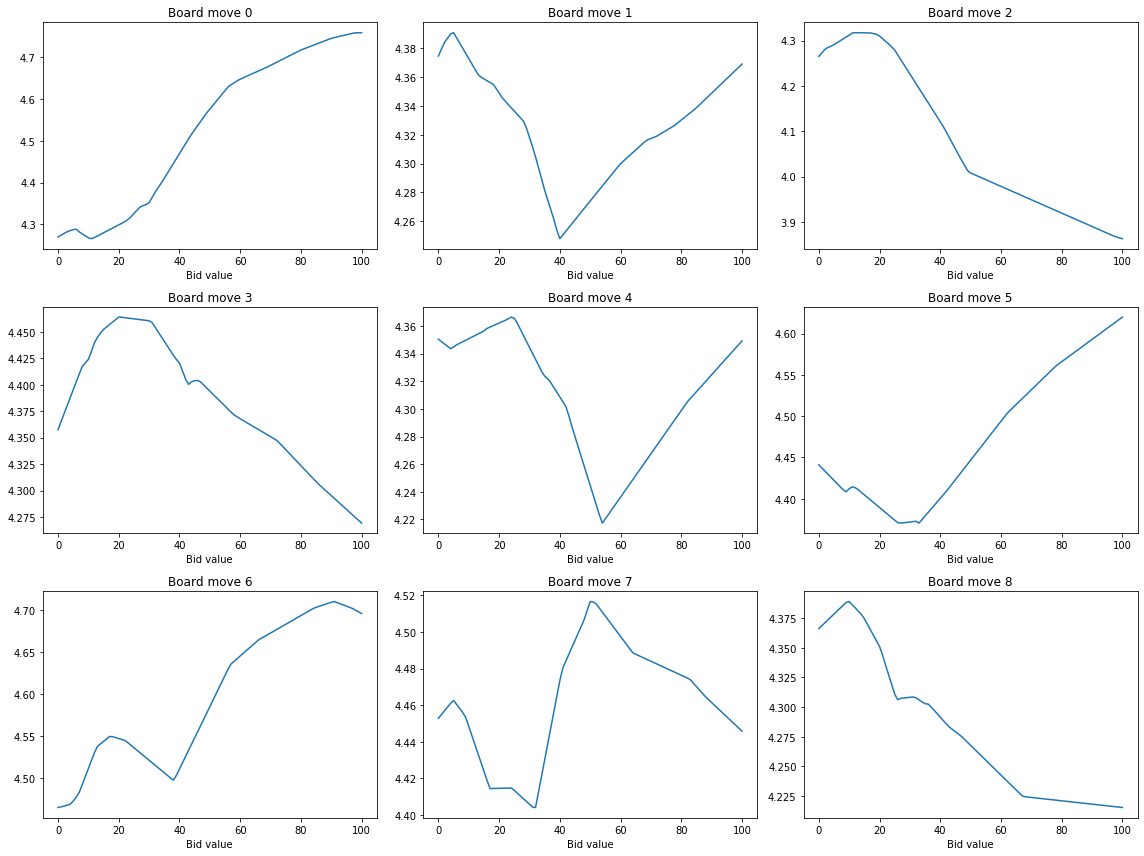

In [195]:
controller.game.reset()
drl_player = drl_players[0]
agent_actor = drl_player.agent.agent.actor_local
agent_critic = drl_player.agent.agent.critic_local
initial_state = drl_player._format_state_to_agent(game.get_state_array()).cuda().unsqueeze(0)

def get_critic_value(bid, board_move):
    action = torch.zeros(10)
    action[0] = bid/200
    action[1+board_move] = 1
    action = action.unsqueeze(0).cuda()
    return agent_critic(initial_state, action).flatten().item()
    
fig, ax = plt.subplots(3, 3, figsize=(16, 12))

for board_move in range(9):
    critic_values = [get_critic_value(bid, board_move) for bid in range(101)]
    axx = ax[board_move//3, board_move%3]
    axx.plot(critic_values)
    axx.set_xlabel('Bid value')
    axx.set_title(f'Board move {board_move}')
fig.tight_layout()
plt.savefig('test.png')
    